In [22]:
import os
import numpy
from scipy.interpolate import interp1d

root = 'logs/'
algos = ['a2c', 'ppo', 'acktr']
game = 'qbert'
lrs = ['lrhalf', 'baseline', 'lrdouble']
lrLabels = {
    'a2c': {
        'lrhalf': '3.5e-4',
        'lrdouble': '1.4e-3',
        'baseline': '7e-4'
    },
    'ppo': {
        'lrhalf': '1.25e-4',
        'lrdouble': '5e-4',
        'baseline': '2.5e-4'
    },
    'acktr': {
        'lrhalf': '3.5e-4',
        'lrdouble': '1.4e-3',
        'baseline': '7e-4'
    }
}
numTrials = 5

def getLogFileNames(trialName):
    folderPath = root + trialName
    logFileNames = [fileName for fileName in os.listdir(folderPath) if 'monitor' in fileName]
    return folderPath, logFileNames
    
def getTrialStats(trialName):
    folderPath, logFileNames = getLogFileNames(trialName)
    #print(folderPath)
    
    logs = []
    for fileName in logFileNames:
        filePath = folderPath + '/' + fileName
        log_lines = []
        with open(filePath, 'r') as log_file:
            log_lines = log_file.readlines()
        logs.append(log_lines[2:])

    numProcesses = len(logs)
    timeSteps = []
    rewards = []
    for log in logs:
        curTimeStep = 0
        for line in log:
            lineParts = line.split(',')
            episodeReward = float(lineParts[0])
            episodeSteps = int(lineParts[1])
            episodeTime = float(lineParts[2])
            curTimeStep += episodeSteps * numProcesses
            timeSteps.append(curTimeStep)
            rewards.append(episodeReward)

    return timeSteps, rewards

def standardize_times(times):
    startTime = times[0]
    endTime = times[-1]
    #numTimes = len(times)
    numTimes = 3000
    return numpy.linspace(startTime, endTime, numTimes)

def standardize_rewards(standardTimes, times, rewards):
    f = interp1d(times, rewards, kind='nearest')
    return f(standardTimes)

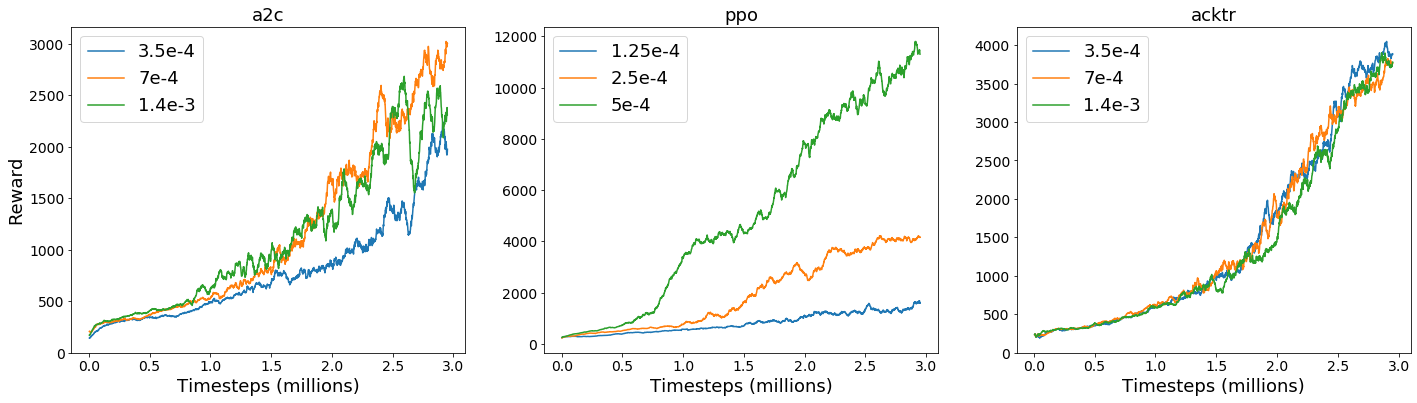

In [23]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1, 3)  
for i, algo in enumerate(algos):
    ax = axs[i]
    ax.set_title(algo, fontsize=18)
    for j, lr in enumerate(lrs):
        standardRewardsList = []
        for trialNum in range(1, numTrials + 1):
            trialNumStr = str(trialNum)
            if lr == 'baseline':
                lrStr = ''
            else:
                lrStr = '_' + lr
            trialName = algo + '_' + game + lrStr + '_' + trialNumStr
            times, rewards = getTrialStats(trialName)
            times, rewards = zip(*sorted(zip(times, rewards)))
            lastTime = numpy.argmax(numpy.array(times) > 3e6)
            times = times[:lastTime]
            rewards = rewards[:lastTime]
            standardTimes = standardize_times(times)
            standardRewards = standardize_rewards(standardTimes, times, rewards)
            standardRewardsList.append(standardRewards)
        standardRewardsMat = numpy.array(standardRewardsList)
        rewardsMean = standardRewardsMat.mean(axis=0)
        rewardsError = standardRewardsMat.std(axis=0)
        smoothRewards = running_mean(rewardsMean, 50)
        smoothError = running_mean(rewardsError, 50)
        ax.plot(standardTimes[:-49] / 1e6, smoothRewards, label=lrLabels[algo][lr])
        #if j == 0:
        #ax.fill_between(standardTimes[:-49] / 1e6, smoothRewards - smoothError, smoothRewards + smoothError, alpha=0.2)
    ax.legend(loc='upper left', fontsize=18)
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#plt.show()
plt.savefig('learning_rate.png', bbox_inches='tight')
plt.show()